## Лабораторная работа №15. Спонтанное деление Cf-252
### Успенский Арсений, 202
#### Цель:
Изучение энергетического спектра осколков спонтанного деления $^{252}Cf$ и определение отношений вероятностей распада $^{252}_{98}Cf$ по различным каналам

In [572]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import math

#### Часть 1. Изучение полного спектра
Входные данные -- энергетический спектр (число регистраций частиц датчика в зависимости от канала, пропорционального энергии):

In [573]:
spectrum = pd.read_table('spectrum.dat', names=['Channel', 'Registrations'])
spectrum = spectrum.assign(Error=np.sqrt(spectrum.iloc[:, 0].to_numpy()))
print(spectrum)

      Channel  Registrations      Error
0           0            878   0.000000
1           1              0   1.000000
2           2              0   1.414214
3           3              0   1.732051
4           4             11   2.000000
...       ...            ...        ...
996       996              0  31.559468
997       997              0  31.575307
998       998              0  31.591138
999       999              0  31.606961
1000     1000              0  31.622777

[1001 rows x 3 columns]


Обрежем лишние данные и построим спектр (в зависимости от номера канала).

In [574]:
channel = spectrum.iloc[:600, 0].to_numpy()
registrations = spectrum.iloc[:600, 1].to_numpy()
error = spectrum.iloc[:600, 2].to_numpy()

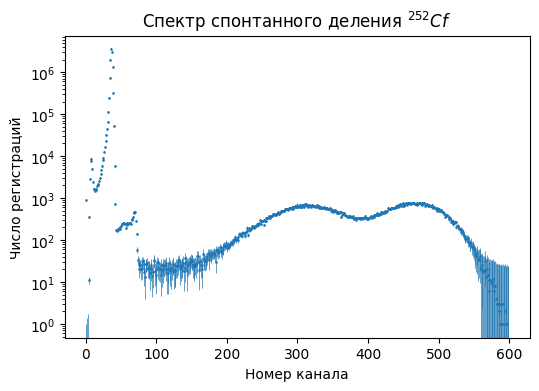

In [575]:
plt.figure(dpi=100)
plt.scatter(channel, registrations, s=0.8)
plt.errorbar(channel, registrations, error, elinewidth=0.5, fmt=',')
plt.yscale('log')
plt.xlabel('Номер канала')
plt.ylabel('Число регистраций')
# plt.ylim([0, 1000])
plt.title('Спектр спонтанного деления $^{252}Cf$')
plt.show()

Первый пик соответсвтует альфа-распаду. Два пика соответствуют осколкам спонтанного деления.
Найдем отношение вероятностей распада как отношение числа зарегестрированных частиц и погрешность:
$$S\left(\frac{P_{\alpha}}{P_{div}}\right) = \sqrt{\left(S_{P_{\alpha}}\frac{1}{P_{div}}\right)^2+\left(S_{P_{div}}\frac{P_{\alpha}}{P_{div}^2}\right)^2}$$

In [576]:
alfa_sum = registrations[:100].sum()
division_sum = registrations[100:].sum()
e_alfa_sum = error[:100].sum()
e_division_sum = error[100:].sum()
e_ratio = math.sqrt((e_alfa_sum / division_sum) ** 2 + (e_division_sum * alfa_sum / division_sum / division_sum) ** 2)
print(f'Отношение вероятности альфа распада к вероятности спонтанного деления: {round(alfa_sum / division_sum, 1)} ± {round(e_ratio, 1)}')

Отношение вероятности альфа распада к вероятности спонтанного деления: 72.7 ± 4.2


Найдем постоянные распада и, соответственно, периоды полураспада:
$$N(t) = N_0\exp\left(-(\lambda_1+\lambda_2)t\right) \Rightarrow \lambda_0 := \lambda_1 + \lambda_2 = \dfrac{\ln{2}}{T_{1/2}}$$
$$\dfrac{\lambda_1}{\lambda_2} = \dfrac{P_\alpha}{P_{div}} \Rightarrow \lambda_2(1 + \dfrac{P_\alpha}{P_{div}}) = \dfrac{\ln{2}}{T_{1/2}} \Rightarrow \lambda_2 = \dfrac{\ln{2}}{T_{1/2}(1 + \dfrac{P_\alpha}{P_{div}})}$$


И соответствующие погрешности: $$ S(\lambda_2) = \dfrac{\ln{2}}{T_{1/2}}\left| \dfrac{S\left(\frac{P_{\alpha}}{P_{div}}\right)}{(1 + \dfrac{P_\alpha}{P_{div}})^2}\right|$$
$$S(\lambda_1) = \sqrt{\left(S(\lambda_2)\dfrac{P_\alpha}{P_{div}}\right)^2+\left(S\left(\frac{P_\alpha}{P_{div}}\right)\lambda_2\right)^2}$$

In [577]:
lmbd2 = np.log(2) / (2.65 * (1 + alfa_sum / division_sum))
lmbd1 = lmbd2 * alfa_sum / division_sum
e_lmbd2 = np.log(2) / 2.65 * math.fabs(e_ratio / ((1 + alfa_sum / division_sum) ** 2))
e_lmbd1 = math.sqrt((e_lmbd2 * alfa_sum / division_sum) ** 2 + (e_ratio*lmbd2) ** 2)
print(f'Период полураспада для спонтанного деления: {round(np.log(2) / lmbd2, 2)} ± {round(np.log(2)*e_lmbd2/lmbd2/lmbd2, 2)} лет')
print(f'Период полураспада для альфа распада: {round(np.log(2) / lmbd1, 2)} ± {round(np.log(2)*e_lmbd1/lmbd1/lmbd1, 2)} лет')

Период полураспада для спонтанного деления: 195.28 ± 11.16 лет
Период полураспада для альфа распада: 2.69 ± 0.22 лет


#### Часть 2. Изучение спектра спонтанного деления
Аппроксимиурем два пика спектра спонтанного деления суммой гауссиан.

The local min of the gaussian fit is [393]


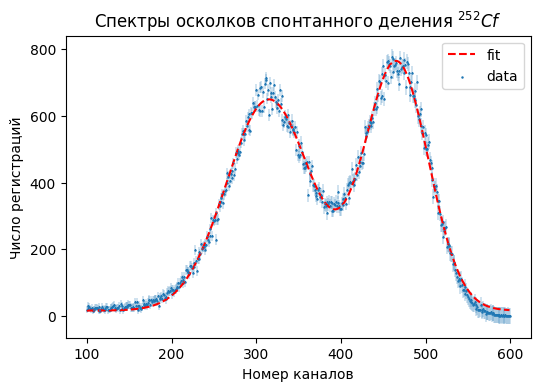

In [578]:
def gauss(x, offset, a, mu, sigma):
    return offset + a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = optimize.curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    perr = np.sqrt(np.abs(np.diag(pcov)))
    return popt, perr


def two_gauss(x, o1, a1, mu1, s1, o2, a2, mu2, s2, offset):
    return (gauss(x, o1, a1, mu1, s1) +
            gauss(x, o2, a2, mu2, s2) + offset)


def two_gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = optimize.curve_fit(two_gauss, x, y,
                                    p0=[min(y), max(y), mean, sigma, min(y), max(y), mean, sigma, min(y)])
    perr = np.sqrt(np.abs(np.diag(pcov)))
    return popt, perr


popt, perr = two_gauss_fit(channel[100:], registrations[100:])
o2, a2, mu2, s2, o1, a1, mu1, s1, offset = popt
e_o2, e_a2, e_mu2, e_s2, e_o1, e_a1, e_mu1, e_s1, e_offset = perr

FWHM1 = 2.35482 * s1
FWHM2 = 2.35482 * s1

# print('The offset of the gaussian baseline is', o1)
# print('The center of the 1 gaussian fit is', mu1)
# print('The center of the 2 gaussian fit is', mu2)
minimum = min(two_gauss(channel[300:500], *popt))
print('The local min of the gaussian fit is', 300 + np.where(two_gauss(channel[300:500], *popt) == minimum)[0])
# print('The sigma of the gaussian fit is', s1)
# print('The maximum intensity of the gaussian fit is', o1 + a1)
# print('The Amplitude of the gaussian fit is', a1)
# print('The FWHM1 of the gaussian fit is', FWHM1)
# print('The FWHM2 of the gaussian fit is', FWHM2)

k = 90.5 / (np.where(two_gauss(channel[300:500], *popt) == minimum)[0] + 300)

plt.figure(dpi=100)
plt.scatter(channel[100:], registrations[100:], s=0.6, label='data')
plt.errorbar(channel[100:], registrations[100:], error[100:], elinewidth=0.3, fmt=',')
plt.plot(channel[100:], two_gauss(channel[100:], *popt), '--r', label='fit')

plt.legend()
plt.title('Спектры осколков спонтанного деления $^{252}Cf$')
plt.xlabel('Номер каналов')
plt.ylabel('Число регистраций')
plt.show()

Теперь, зная энергию, соответствующую минимуму, мы можем градуировать наш график, то есть представить спектр в зависимости от энергии частицы. По данному графику определим энергии наиболее вероятных осколков.

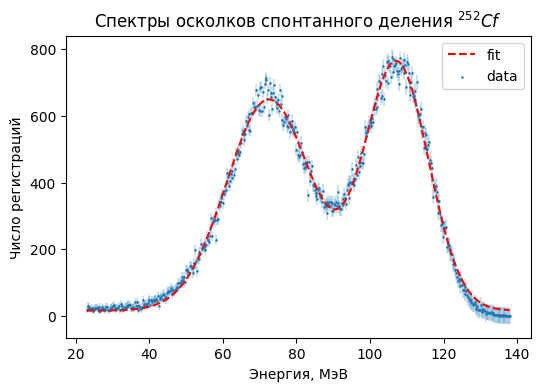

Максимум первого пика:  72.53  ±  0.07 МэВ
Полуширина первого пика:  27.1  ±  0.2 МэВ
Максимум второго пика:  107.24  ±  0.07 МэВ
Полуширина второго пика:  20.47  ±  0.13 МэВ


In [579]:
energy2 = channel[100:] * k
reg2 = registrations[100:]

plt.figure(dpi=100)
plt.scatter(energy2, reg2, s=0.6, label='data')
plt.errorbar(energy2, reg2, error[100:], elinewidth=0.3, fmt=',')
plt.plot(energy2, two_gauss(channel[100:], *popt), '--r', label='fit')

plt.legend()
plt.title('Спектры осколков спонтанного деления $^{252}Cf$')
plt.xlabel('Энергия, МэВ')
plt.ylabel('Число регистраций')
plt.show()

e1 = float(mu1 * k)
e_e1 = float(e_mu1 * k)
e2 = float(mu2 * k)
e_e2 = float(e_mu1 * k)
print('Максимум первого пика: ', round(e1, 2), ' ± ', round(e_e1, 2), 'МэВ')
print('Полуширина первого пика: ', round(float(2.35482 * s1 * k), 2), ' ± ', round(float(2.35482 * e_s1 * k), 2), 'МэВ')
print('Максимум второго пика: ', round(e2, 2), ' ± ', round(e_e2, 2), 'МэВ')
print('Полуширина второго пика: ', round(float(2.35482 * s2 * k), 2), ' ± ', round(float(2.35482 * e_s2 * k), 2), 'МэВ')

Чтобы учесть поправку на ионизационный эффект, необходимо прибавить к полученным значениям 4 ± 1 МэВ.
Теперь найдем наиболее вероятные массы осколков:
$$\begin{cases} \frac{E_1}{E_2} = \frac{M_2}{M_1}\\ M_1 + M_2 = 250\end{cases} \Rightarrow M_1 = \dfrac{250}{1 + \frac{E_1}{E_2}};\;M_2 = \dfrac{250}{1 + \frac{E_2}{E_1}}$$

$$S\left(\frac{E_1}{E_2}\right) = \sqrt{\left(S_{E_1}\frac{1}{E_2}\right)^2+\left(S_{E_2}\frac{E_1}{E_2^2}\right)^2}$$
$$S(M_1) = \frac{250\cdot S\left(\frac{E_1}{E_2}\right)}{\left(1 + \frac{E_1}{E_2}\right)^2}$$
$$S(M_2) = \sqrt{\left(S\left(\dfrac{E_1}{E_2}\right)M_1\right)^2+\left(S(M_1)\frac{E_1}{E_2}\right)^2}$$

In [580]:
e1 += 4
e2 += 4
e1_e2 = e1/e2
e_e1_e2 = math.sqrt((e_e1/e2)**2+(e_e2*e1/e2/e2)**2)
m1 = 250/(1 + e1_e2)
m2 = 250/(1 + e2/e1)
e_m1 = 250*e_e1_e2/((1 + e1_e2)**2)
e_m2 = math.sqrt((e_e1_e2*m1)**2+(e_m1*e1_e2)**2)
print(f'Масса легкого осколка: {round(m2,2)} ± {round(e_m2,2)}')
print(f'Масса тяжелого осколка: {round(m1,2)} ± {round(e_m1,2)}')

Масса легкого осколка: 101.9 ± 0.12
Масса тяжелого осколка: 148.1 ± 0.07


#### Часть 3. Изучение пика альфа-частицы
Снова градуируем спектр отдельно для альфа-частицы. Аппроксимиурем пик гауссианой. Зная полуширину пика, найдем абсолютную и относительную разрешающую способность установки.

The local min of the gaussian fit is [36]


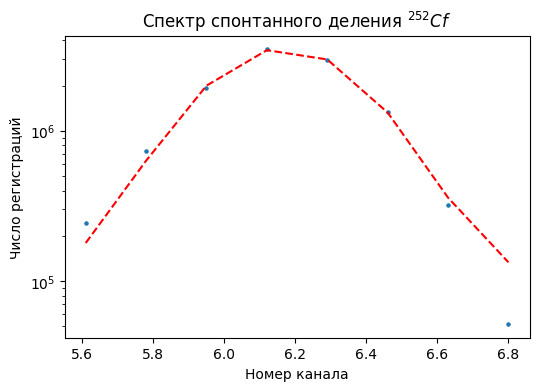

Полуширина пика:  0.47  ±  0.2 МэВ
Относительное разрешение установки:  0.08  ±  0.03


In [581]:
popt, perr = gauss_fit(channel[33:41], registrations[33:41])
offset, a, mu, sigma = popt
e_ffset, e_a, e_mu, e_sigma = perr

maximum = max(gauss(channel[33:41], *popt))
print('The local min of the gaussian fit is', 33 + np.where(gauss(channel[33:41], *popt) == maximum)[0])
ka = 6.12 / (33 + np.where(gauss(channel[33:41], *popt) == maximum)[0])
energy1 = channel[33:41] * ka

plt.figure(dpi=100)
plt.scatter(energy1, registrations[33:41], s=5)
plt.errorbar(energy1, registrations[33:41], error[33:41], elinewidth=1, fmt=',')
plt.plot(energy1, gauss(channel[33:41], *popt), '--r', label='fit')
plt.yscale('log')
plt.xlabel('Номер канала')
plt.ylabel('Число регистраций')
# plt.ylim([0, 1000])
plt.title('Спектр спонтанного деления $^{252}Cf$')
plt.show()

# print('Максимум пика: ', round(float(mu * ka), 3), ' ± ', round(float(e_mu * ka), 3), 'МэВ')
print('Полуширина пика: ', round(float(2.35482 * sigma * ka), 2), ' ± ', round(float(2.35482 * e_s1 * k), 2), 'МэВ')
print('Относительное разрешение установки: ', round(float(2.35482 * sigma * ka / 6.12), 2), ' ± ', round(float(2.35482 * e_s1 * k / 6.12), 2))

### Основные итоги работы
В ходе работы был получен спектр осколков спонтанного деления и альфа-распада $^{252}Cf$. Из спектра были получены:

In [582]:
print('Максимумы энергетического спектра осколков:')
print('Максимум первого пика: ', round(e1, 2), ' ± ', round(e_e1, 2), 'МэВ')
print('Максимум второго пика: ', round(e2, 2), ' ± ', round(e_e2, 2), 'МэВ\n')
print('Наиболее вероятные массы осколков:')
print(f'Масса легкого осколка: {round(m2,2)} ± {round(e_m2,2)}')
print(f'Масса тяжелого осколка: {round(m1,2)} ± {round(e_m1,2)}\n')
print('Абсолютные и относительное разрешение установки (по альфа-пику):')
print('Полуширина пика: ', round(float(2.35482 * sigma * ka), 2), ' ± ', round(float(2.35482 * e_s1 * k), 2), 'МэВ')
print('Относительное разрешение установки: ', round(float(2.35482 * sigma * ka / 6.12), 2), ' ± ', round(float(2.35482 * e_s1 * k / 6.12), 2),'\n')
print('Отношение вероятностей распада по каналам спонтанного деления и альфа-распада:')
print(f'Отношение вероятности альфа распада к вероятности спонтанного деления: {round(alfa_sum / division_sum, 1)} ± {round(e_ratio, 1)}\n')
print('Периоды полураспадов по каналам спонтанного деления и альфа-распада:')
print(f'Период полураспада для спонтанного деления: {round(np.log(2) / lmbd2, 2)} ± {round(np.log(2)*e_lmbd2/lmbd2/lmbd2, 2)} лет')
print(f'Период полураспада для альфа распада: {round(np.log(2) / lmbd1, 2)} ± {round(np.log(2)*e_lmbd1/lmbd1/lmbd1, 2)} лет\n')

Максимумы энергетического спектра осколков:
Максимум первого пика:  76.53  ±  0.07 МэВ
Максимум второго пика:  111.24  ±  0.07 МэВ

Наиболее вероятные массы осколков:
Масса легкого осколка: 101.9 ± 0.12
Масса тяжелого осколка: 148.1 ± 0.07

Абсолютные и относительное разрешение установки (по альфа-пику):
Полуширина пика:  0.47  ±  0.2 МэВ
Относительное разрешение установки:  0.08  ±  0.03 

Отношение вероятностей распада по каналам спонтанного деления и альфа-распада:
Отношение вероятности альфа распада к вероятности спонтанного деления: 72.7 ± 4.2

Периоды полураспадов по каналам спонтанного деления и альфа-распада:
Период полураспада для спонтанного деления: 195.28 ± 11.16 лет
Период полураспада для альфа распада: 2.69 ± 0.22 лет

